In [32]:
%env CUDA_VISIBLE_DEVICES=4

env: CUDA_VISIBLE_DEVICES=4


In [33]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import functools

In [34]:
rfft = functools.partial(torch.fft.rfftn,dim=[0,1,2])
irfft = functools.partial(torch.fft.irfftn,dim=[0,1,2])

def divide_no_nan(a,b):
    return torch.nan_to_num(a/b,nan=0.0, posinf=0., neginf=0.)


In [38]:
# This should be a subclass of POU-net that wraps the forward() method! 

class IdentityOp:
    def forward(self, X):
        return X

class Sim:
    def __init__(self,nx,ny,nz,Lx,Ly,Lz,nu,dt):
        self.nx = nx
        self.ny = ny
        self.nz = nz
        self.Lx = Lx
        self.Ly = Ly
        self.Lz = Lz
        self.nu = nu
        self.k = torch.tensor(np.stack(np.meshgrid(np.fft.fftfreq(nx)*nx*2.*np.pi/Lx,
                                       np.fft.fftfreq(ny)*ny*2.*np.pi/Ly,
                                       np.fft.rfftfreq(nz)*nz*2.*np.pi/Lz,indexing='ij'),axis=-1)).cdouble()

        self.x = torch.tensor(np.stack(np.meshgrid(np.arange(nx)/nx*Lx,
                    np.arange(ny)/ny*Ly,
                    np.arange(nz)/nz*Lz,indexing='ij'),axis=-1))

        self.xi = (self.x[...,0]>=np.pi/4)*(self.x[...,0]<=Lx-np.pi/4)

        self.knorm2 = torch.sum(self.k**2,-1).double()
        self.Ainv =  torch.tensor(1./(1.+nu*np.einsum('...j,...j->...',self.k,self.k)))
        self.filt = (np.sqrt(self.knorm2)<=2./3*(min(self.nx,self.ny,self.nz)/2+1))
        self.filt2 = (np.sqrt(self.knorm2)<=1./3*(min(self.nx,self.ny,self.nz)/2+1))
        self.Ainv = self.Ainv * self.filt
        self.dt = dt
        self.shapef = [nx,ny,nz]
        self.shapeh = [nx,ny,nz//2+1]
        self.forcing = 0.*self.k
        self.forcing[4,4,4,0] = 10.

        self.eta = 1e-3
        self.nu_num = 1e-3
        self.op = IdentityOp() # identity by default
    
    def genIC(self):
        h = torch.tensor(np.random.normal(0,1,(self.nx,self.ny,self.nz,3)))
        hh = rfft(h) * self.filt2[...,None]
        proj = self.k*(torch.sum(self.k*hh,axis=-1)/self.knorm2)[...,None]
        proj[0]=0
        u0 = irfft(hh - proj)
        return u0

    def NSupd(self,u): # Navier-stokes update
        uh = rfft(u)
        u2h = rfft(torch.einsum('...i,...j->...ij',u,u))
        return irfft(self.Ainv[...,None]*(
            uh + self.dt*(-1.j*torch.einsum('...j,...ij->...i',self.k,u2h) 
                 + 1.j*divide_no_nan(torch.einsum('...i,...j,...k,...jk->...i',self.k,self.k,self.k,u2h),self.knorm2[...,None])
                 ))
            )

    # set the neural operator for correction
    def set_operator(self, op):
        self.op = op
    
    # This should perhaps use super().forward()
    #use operator learning here to correct for missing physics
    def learnedCorrection(self,u):
        print(u.shape)
        return self.op.forward(u)
        # __call__ is necessary for hooks... <- but this should already happen outside!

    # Also this should be the wrapper on the forward method
    # This needs to output intermediate time-steps to get full loss!
    # GOTCHA: this probably needs torch.vmap to work properly across a batch
    def evolve(self,u0,n, intermediate_outputs=False):
        u = u0
        outputs = []
        for _ in range(n):
            u = self.learnedCorrection(self.NSupd(u))
            outputs.append(u)
        return torch.stack(outputs,axis=-1) if intermediate_outputs else outputs[-1]
        # stacking on the first dimension is correct b/c first dimension is the time dimension!

In [36]:
from lightning_utils import *
from POU_net import POU_net

class POU_NetSimulator(POU_net):
    def __init__(self, *args, simulator: Sim, n_steps: int, **kwd_args):
        super().__init__(*args, **kwd_args)
        simulator.set_operator(super()) # this will internally call super().forward(X)
        self.simulator = simulator
        self.n_steps = n_steps # n timesteps for PDE evolution
    def forward(self, X):
        #X.shape==[batch, x, y, ...]
        evolve = lambda u0: self.simulator.evolve(u0, n=self.n_steps, intermediate_outputs=True)
        evolve = torch.vmap(evolve) # vmap across batch dim
        return evolve(X)

In [23]:
"""
# sets up simulation

# number of grid points
nx = ny = nz = 256
#length of domain
Lx = Ly = Lz = 2*np.pi
# viscosity
nu = 0.003
# timestep
dt = 1e-5
sim = Sim(nx,ny,nz,Lx,Ly,Lz,nu,dt)
""";

In [42]:
# sets up simulation

# number of grid points
nx = ny = nz = 256
#nx,ny,nz=(77, 26, 103)
#length of domain
Lx = Ly = Lz = 2*np.pi
# viscosity
nu = 5e-5
# timestep
dt = 0.0013
sim = Sim(nx,ny,nz,Lx,Ly,Lz,nu,dt)

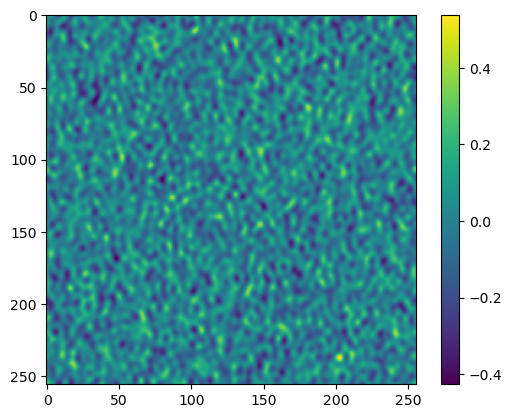

In [43]:
# generate initial condition (IC)
u0 = sim.genIC()
plt.imshow(u0[:,:,0,0]);plt.colorbar()

In [44]:
# evolve by IC by 4 timesteps
plt.imshow(sim.evolve(u0,4)[:,0,:,0]);plt.colorbar()

RuntimeError: "nan_to_num" not implemented for 'ComplexDouble'

In [ ]:
evolved = sim.evolve(u0,4)

In [9]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import torch
from torch import nn
import numpy as np
import matplotlib.pyplot as plt
import pytorch_lightning as L
import torch.nn.functional as F
torch.set_float32_matmul_precision('medium')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [10]:
from lightning_utils import *
from MOR_Operator import MOR_Operator
from POU_net import POU_net

In [28]:
import os
import h5py

# TODO: load & store dataset in one big hdf5 file (more efficient I/O)
class JHTDB_Channel(torch.utils.data.Dataset):
    def __init__(self, path:str, time_chunking=20):
        self.path=path
        self.time_chunking=time_chunking
    def __len__(self):
        return len(os.listdir(self.path))//(2*self.time_chunking)
    def __getitem__(self, index):
        files = []
        velocity_fields = []
        for i in range(index*self.time_chunking, (index+1)*self.time_chunking):
            i+=1
            files.append(h5py.File(f'{self.path}/channel_t={i}.h5', 'r')) # keep open for stacking
            velocity_fields.append(files[-1][f'Velocity_{i:04}']) # :04 zero pads to 4 digits
        velocity_fields = torch.swapaxes(torch.as_tensor(np.stack(velocity_fields)), -1, 0)
        return velocity_fields[...,0], velocity_fields[...,1:] # X=IC, Y=sol

In [29]:
dataset = JHTDB_Channel('data/turbulence_output')
train_len = int(0.8*len(dataset))
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_len, len(dataset)-train_len])
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=2, num_workers=16, pin_memory=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=2, num_workers=8)
print(f'{len(dataset)=}\n{len(train_loader)=}\n{len(val_dataset)=}')

len(dataset)=34
len(train_loader)=14
len(val_dataset)=7


In [30]:
IC_0, Sol_0 = dataset[0]
print(f'{IC_0.shape=}\n{Sol_0.shape=}')

IC_0.shape=torch.Size([3, 77, 26, 103])
Sol_0.shape=torch.Size([3, 77, 26, 103, 19])


In [27]:
%pdb
ndims=3

#Expert = lambda **kwd_args: MOR2dOperator(n_layers=1, **kwd_args) # works b/c only 1 layer
Expert = lambda: MOR_Operator(ndims=ndims) # works (with 32 modes)
#Expert = lambda: MOR2dOperator(k_modes=16) # only kind of works
#Expert = CNN2d # works

# train model
model = POU_net(Expert, 1, n_inputs=ndims, lr=0.001, T_max=25)
trainer = L.Trainer(max_epochs=1000, accelerator='gpu', devices=1)
trainer.fit(model=model, train_dataloaders=train_loader, val_dataloaders=val_loader)

Automatic pdb calling has been turned OFF


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]

  | Name       | Type           | Params
----------------------------------------------
0 | gating_net | FieldGatingNet | 2.3 K 
1 | experts    | ModuleList     | 201 M 
----------------------------------------------
201 M     Trainable params
0         Non-trainable params
201 M     Total params
805.637   Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

AssertionError: 